## Data Treating

In [3]:
# ===========================================
# 0. Enviroment Set-up
# ===========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns



# matplotlib set up
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [4]:
# ===========================================
# 1.1 Data Loading
# ===========================================
csv_path = "Data/SPY_2020-07-01_2021-07-01_minute.csv"
df = pd.read_csv(csv_path)

data_raw = df.copy()
data_raw = data_raw.set_index('timestamp')
# data_raw = data_raw.head(10000).set_index('timestamp')

In [5]:
data_raw.head(5)

,open,high,low,close,volume,dollar_volume,tick_count,trade_size_mean,trade_size_std,zero_return_count,price_direction_ratio,large_trade_count,large_trade_volume,vwap,large_trade_ratio,large_trade_volume_ratio
timestamp,,,,,,,,,,,,,,,,
2020-07-01 04:00:00-04:00,308.68,308.84,308.68,308.83,656.0,202545.01,16,41.000000,42.842347,9,0.250000,0,0.0,308.757637,0.0,0.0
2020-07-01 04:01:00-04:00,308.78,308.79,308.74,308.74,2594.0,800940.16,9,288.222222,219.928271,4,0.222222,0,0.0,308.766446,0.0,0.0
2020-07-01 04:02:00-04:00,308.77,308.84,308.77,308.84,807.0,249212.90,4,201.750000,235.213910,2,0.500000,0,0.0,308.814002,0.0,0.0
2020-07-01 04:03:00-04:00,308.82,308.84,308.82,308.84,89.0,27485.78,3,29.666667,9.073772,2,0.333333,0,0.0,308.828989,0.0,0.0
2020-07-01 04:04:00-04:00,308.84,308.90,308.84,308.90,501.0,154738.60,5,100.200000,86.024415,2,0.600000,0,0.0,308.859481,0.0,0.0


In [8]:
# ===========================================
# 1.2 Labels 
# ===========================================

# ---------- Labels & Forward Log Returns  ----------

H   = 5        # 5 bar lookahead
TAU = 0.01     # 1% threshold

# ★ Log Returns：ln(P_{t+H} / P_t)
fwd_ret_full = np.log(data_raw['close'].shift(-H) / data_raw['close'])

labels = np.select(
    [fwd_ret_full >  TAU,
     fwd_ret_full < -TAU],
    [ 1,              -1],        # Buy=1, Sell=-1
    default = 0
)

labels = pd.Series(labels, index=fwd_ret_full.index)\
           .where(fwd_ret_full.notna())

data_raw['action'] = labels
data_raw = data_raw.dropna(subset=['action'])

In [9]:
data_raw[data_raw['action'] != 0].size

2074

In [10]:
# ===========================================
# 1.3 Features Selection
# ===========================================
from ta.momentum import RSIIndicator

# Define columns for Min-Max normalization
unbounded_features_cols = [
    'open', 'high', 'low', 'close',
    'volume', 'vwap', 'dollar_volume',
    'tick_count', 'trade_size_mean',
    'zero_return_count', 'large_trade_count',
    'large_trade_volume'
]

# features selecting function
def compute_bounded_indicators(
    df: pd.DataFrame,
    unbounded_cols: list[str],
    rsi_period: int = 14
) -> pd.DataFrame:
    """
    For each column in the specified list "unbounded_cols" in df, compute the RSI as a bounded indicator
    and append it as a new column. Automatically drop all initial rows with NaN values due to RSI's rolling
    window computation, and fill any remaining NaNs using linear interpolation.

    Parameters
    ----------
    df : pd.DataFrame
        The original DataFrame, which should contain at least the columns listed in unbounded_cols.
        These columns are assumed to have no missing values initially.
    unbounded_cols : List[str]
        A list of column names for which RSI (bounded indicator) will be computed, e.g.:
        ['open', 'high', 'low', 'close', 'volume', 'vwap', 'dollar_volume',
         'tick_count', 'trade_size_mean', 'zero_return_count',
         'large_trade_count', 'large_trade_volume']
    rsi_period : int, default 14
        The window size for RSI computation. The RSI output range is [0, 100].

    Returns
    ----------
    df_out : pd.DataFrame
        The resulting DataFrame containing all original columns plus RSI columns
        (named "rsi(col)") for each column in unbounded_cols. All leading rows with NaN values
        are dropped, and remaining scattered NaNs are linearly interpolated.
    """

    data = df.copy()

    # 1. Compute RSI for each specified unbounded column
    for col in unbounded_cols:
        # RSIIndicator expects a pd.Series as input
        rsi_obj = RSIIndicator(close=data[col], window=rsi_period)
        data[f"rsi({col})"] = rsi_obj.rsi()

    # 2. Find the first row without any NaN and drop all rows before it
    mask_any_na = data.isna().any(axis=1)
    if mask_any_na.all():
        # If all rows contain NaNs (edge case), return an empty DataFrame with same columns
        return data.iloc[0:0]

    first_valid_idx = mask_any_na.idxmin()  # First False (i.e., no NaN) row index
    data = data.loc[first_valid_idx:].copy()

    # 3. Apply linear interpolation to fill remaining scattered NaNs
    data = data.interpolate(method="linear", limit_direction="forward", axis=0)

    # (Optional) If there are still NaNs at the tail, may choose to backfill:
    # data = data.fillna(method="bfill")

    return data

data_featured = compute_bounded_indicators(data_raw, unbounded_cols=unbounded_features_cols)
data_featured = data_featured.drop(columns=unbounded_features_cols)

In [11]:
data_featured.sample(5)

,trade_size_std,price_direction_ratio,large_trade_ratio,large_trade_volume_ratio,action,rsi(open),rsi(high),rsi(low),rsi(close),rsi(volume),rsi(vwap),rsi(dollar_volume),rsi(tick_count),rsi(trade_size_mean),rsi(zero_return_count),rsi(large_trade_count),rsi(large_trade_volume)
timestamp,,,,,,,,,,,,,,,,,
2020-08-27 11:38:00-04:00,266.134977,0.153533,0.025815,0.257327,0.0,57.750820,60.021346,60.400024,59.594705,48.673330,60.091892,48.677114,48.679219,49.377681,49.710287,49.783594,48.579112
2020-12-07 07:25:00-05:00,53.631148,0.400000,0.000000,0.000000,0.0,45.670985,44.749382,39.363787,40.170238,47.480173,40.480642,47.480184,48.373398,47.255719,46.675267,47.952498,47.970554
2020-10-20 17:50:00-04:00,197.989899,0.000000,0.000000,0.000000,0.0,56.278242,50.995835,61.589513,56.320168,47.393229,53.389469,47.393382,46.537731,47.556952,47.293813,46.416776,47.884277
2021-06-14 09:25:00-04:00,185.690281,0.232558,0.069767,0.426803,0.0,53.223472,52.260288,51.807696,50.501679,51.859170,51.307889,51.859500,53.144209,50.929109,52.257727,52.522384,52.842444
2021-03-12 06:25:00-05:00,146.961163,0.250000,0.000000,0.000000,0.0,46.283629,50.058262,47.116575,51.118283,50.070404,49.361669,50.070229,48.966988,52.905261,49.270058,47.681805,47.988782


In [12]:
# seperate action_labels for creating y
action_labels = data_featured["action"].values

In [13]:
action_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
# ===========================================
# 1.4 Standardization + PCA
# ===========================================

# Standardize features to zero mean and unit variance
scaler = StandardScaler()
data_std  = scaler.fit_transform(data_featured)

# Let PCA determine how many principal components are needed to explain ≥90% of the variance
pca_full = PCA().fit(data_std)
cum_var  = np.cumsum(pca_full.explained_variance_ratio_)   # Cumulative explained variance
n_pc     = np.argmax(cum_var >= 0.90) + 1    # First index where cumulative variance ≥ 90%

print(f"{n_pc} principal components are sufficient to explain ≥90% of the variance")

pca = PCA(n_components=n_pc, random_state=42)
data_pca = pca.fit_transform(data_std)

7 principal components are sufficient to explain ≥90% of the variance


In [15]:
data_pca.shape

(220138, 7)

In [45]:
# ===========================================
# 1.5 Discovering Data Patterns
# ===========================================

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from Utility import kmean_job

import os


scores = {}
futures = []

with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    for k in range(2, 6):
        fut = executor.submit(kmean_job, k, data_pca)
        futures.append(fut)

    for fut in tqdm(as_completed(futures), total=len(futures), desc="计算各 k 的 silhouette_score"):
        k_val, score_val = fut.result()
        scores[k_val] = score_val

best_k = max(scores, key=scores.get)
print("最佳 k (silhouette max) =", best_k)
print("各 k 的分数详情：", scores)


kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(data_pca)

计算各 k 的 silhouette_score: 100%|██████████| 4/4 [07:34<00:00, 113.58s/it]


最佳 k (silhouette max) = 2
各 k 的分数详情： {5: np.float64(0.23323700098477784), 3: np.float64(0.23680712367968196), 4: np.float64(0.24290344336304082), 2: np.float64(0.24805453511566872)}


In [17]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(data_pca)

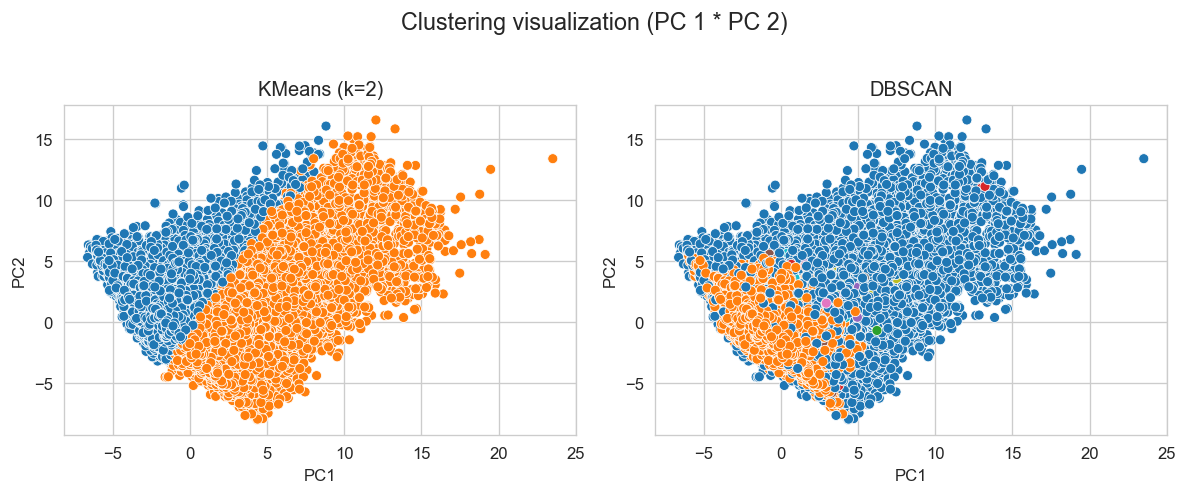

In [18]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# KMeans
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_km.astype(str),
    palette="tab10", ax=axes[0], legend=False
)
axes[0].set_title(f"KMeans (k={best_k})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# DBSCAN
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_db.astype(str),
    palette="tab10", ax=axes[1], legend=False
)
axes[1].set_title("DBSCAN")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.suptitle("Clustering visualization (PC 1 * PC 2)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [19]:
feature_array = data_pca.copy()
target_array = action_labels.copy()
feature_array.shape, target_array.shape

((220138, 7), (220138,))

In [20]:
# ===========================================
# 1.6 Creating X，y data
# ===========================================

seq_len = 16

n_samples = len(action_labels) - seq_len

X = []
y = []

# Populate X and y using a sliding window
for i in range(n_samples):
    # X[i] = features_array[i : i+seq_len]
    X.append(feature_array[i : i + seq_len, :])
    # y[i] = target_array[i+seq_len]
    y.append(target_array[i + seq_len])

X = np.array(X); y = np.array(y)


In [21]:
X.shape, y.shape

((220122, 16, 7), (220122,))

In [22]:
train_pct = 0.7
valid_pct = 0.15
test_pct = 0.15

total_len = X.shape[0]

train_len = int(train_pct * total_len)
valid_len = int(valid_pct * total_len)
test_len = int(test_pct * total_len)

X_train = X[:train_len]
X_valid = X[train_len:train_len+valid_len]
X_test = X[train_len+valid_len:]

y_train = y[:train_len]
y_valid = y[train_len:train_len+valid_len]
y_test = y[train_len+valid_len:]


print("X shape:", X_train.shape, X_valid.shape, X_test.shape)
print("y shape:", y_train.shape, y_valid.shape, y_test.shape)


X shape: (154085, 16, 7) (33018, 16, 7) (33019, 16, 7)
y shape: (154085,) (33018,) (33019,)


In [23]:
# Flatting Data
# Assume X_train.shape == (154088, 16, 7) and y_train.shape == (154088,)
# Reshape X_train from (n_samples, seq_len, n_feats) to (n_samples, seq_len * n_feats)
n_samples, seq_len, n_feats = X_train.shape

X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)
X_valid_flat = X_valid.reshape(X_valid.shape[0], seq_len * n_feats)
X_test_flat  = X_test.reshape(X_test.shape[0],  seq_len * n_feats)

In [24]:
print(X_train.shape)         # (154088, 16, 7)
X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)
print(X_train.shape)         # 仍然是 (154088, 16, 7)
print(X_train_flat.shape)    # (154088, 112)

(154085, 16, 7)
(154085, 16, 7)
(154085, 112)


## Model Building - FROM LIAO ZIYU

#### 2d model

In [25]:
# 0 Prereqs – keep these in one cell
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.linear_model   import LogisticRegression
from sklearn.svm           import SVC
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score, f1_score,
                             classification_report, confusion_matrix)

plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

In [26]:
# 1 Pick up the arrays you already built

idx_all   = data_featured.index[seq_len:]  

idx_all   = data_featured.index[seq_len:]               # timeline after windowing
idx_test  = idx_all[len(y_train)+len(y_valid):]         # align with y_test

In [30]:
# 2 Model zoo (6 total)

sk_models = {
    "LogReg-Softmax": LogisticRegression(
        multi_class='multinomial', class_weight='balanced',
        max_iter=400, n_jobs=-1, C=1.0, solver='lbfgs'),

    "Linear-SVM":     SVC(class_weight='balanced', C=1.0, kernel='linear'),

    "k-NN (k=15)":    KNeighborsClassifier(n_neighbors=15, weights='distance'),

    "Random Forest":  RandomForestClassifier(
        n_estimators=400, min_samples_leaf=25,
        n_jobs=-1, random_state=42),

    "Hist GBDT":      HistGradientBoostingClassifier(
        max_depth=4, learning_rate=0.05, max_iter=600,
        class_weight='balanced', random_state=42),

    "2-Layer MLP":    MLPClassifier(hidden_layer_sizes=(128, 64),
        activation='relu', batch_size=2**12, early_stopping=True,
        alpha=1e-4, random_state=42)
}

param_grids = {
    "LogReg-Softmax": {
        "C": [0.01, 0.1, 1.0], 
        "solver": ["lbfgs"], 
        "penalty": ["l2"]
        # 如果要调更多项，比如 class_weight 可以填在这里
    },
    "Linear-SVC": {
        "C": [0.01, 0.1, 1.0],
    },
    "k-NN": {
        "n_neighbors": [5, 10, 15],
        "weights": ["uniform", "distance"],
        "p": [1, 2]  # p=1 (曼哈顿距离), p=2 (欧氏距离)
    },
    "Random Forest": {
        "n_estimators": [200, 400],
        "max_depth": [4, 6],
        "min_samples_leaf": [1, 5, 10],
        "max_features": ["sqrt", "log2"]
    },
    "Hist GBDT": {
        "max_depth": [4, 6],
        "learning_rate": [0.01, 0.1],
        "max_iter": [200, 600],
        # class_weight 在初始化时已经设置为 balanced，如果要调，可以在此处添加
    },
    "2-Layer MLP": {
        "hidden_layer_sizes": [(128, 64), (256, 128)],
        "activation": ["relu", "tanh"],
        "alpha": [1e-5, 1e-3],
        "learning_rate_init": [1e-4]
    }
}


In [36]:
X_train_flat_demo = X_train_flat[:10000]
y_train_demo = y_train[:10000]

In [37]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 3. 设置交叉验证策略
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. 循环遍历每个模型并进行 GridSearchCV
best_estimators = {}  # 用于存储每个模型的最佳估计器
best_params = {}      # 存储每个模型的最佳参数
best_scores = {}      # 存储每个模型的最佳交叉验证得分

for name, model in sk_models.items():
    print(f"\n>> Tuning {name} ...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="accuracy",   # 或者换成其他你需要的指标，如 'roc_auc_ovr', 'f1_macro' 等
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train_flat_demo, y_train_demo)
    best_estimators[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    best_scores[name] = grid.best_score_
    print(f"  - Best score: {grid.best_score_:.4f}")
    print(f"  - Best params: {grid.best_params_}")

# 5. 输出所有模型的调参结果
print("\n\n=== Summary of Best Models ===")
for name in sk_models.keys():
    print(f"{name}:")
    print(f"    Best CV score : {best_scores[name]:.4f}")
    print(f"    Best params   : {best_params[name]}")
    print("-----------------------------------------------")


>> Tuning LogReg-Softmax ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'mul

  - Best score: 0.9982
  - Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

>> Tuning Linear-SVM ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase t

  - Best score: 0.9992
  - Best params: {'C': 0.01, 'dual': False, 'loss': 'squared_hinge'}

>> Tuning k-NN (k=15) ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


  - Best score: 0.9991
  - Best params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

>> Tuning Random Forest ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


  - Best score: 0.9989
  - Best params: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

>> Tuning Hist GBDT ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


  - Best score: 0.9989
  - Best params: {'learning_rate': 0.01, 'max_depth': 4, 'max_iter': 600}

>> Tuning 2-Layer MLP ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..............C=0.1, dual=False, loss=squared_hinge; total time=   1.6s
[CV] END ................n_neighbors=5, p=2, weights=uniform; total time=   0.2s
[CV] END ...............n_neighbors=10, p=1, weights=uniform; total time=   0.9s
[CV] END ...............n_neighbors=15, p=1, weights=uniform; total time=   0.9s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=5, n_estimators=200; total time=   4.0s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=10, n_estimators=200; total time=   3.7s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, n_estimators=200; total time=   2.6s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=5, n_estimators=200; total time=   2.5s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=5, n_estimators=400; total time=   4.8s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, n_estimators=400; total time=   7.9s
[CV] E

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..............C=0.1, dual=False, loss=squared_hinge; total time=   2.0s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   1.0s
[CV] END ...............n_neighbors=10, p=2, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=15, p=1, weights=uniform; total time=   0.9s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=400; total time=   7.7s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, n_estimators=200; total time=   2.5s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=5, n_estimators=200; total time=   2.4s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=5, n_estimators=400; total time=   5.2s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=5, n_estimators=200; total time=   4.4s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=10, n_estimators=200; total time=   4.6s
[CV] E

In [39]:
sk_models = {
    "LogReg-Softmax": LogisticRegression(
        multi_class='multinomial', class_weight='balanced',
        max_iter=400, n_jobs=-1, C=1.0, solver='lbfgs', penalty='l2'),

    "Linear-SVM":     SVC(class_weight='balanced', C=0.01, kernel='linear'),

    "k-NN":    KNeighborsClassifier(n_neighbors=5, p=2, weights='distance', n_jobs=-1),

    "Random Forest":  RandomForestClassifier(
        n_estimators=200, min_samples_leaf=1,
        n_jobs=-1, random_state=42, max_depth=4, max_features='sqrt',),

    "Hist GBDT":      HistGradientBoostingClassifier(
        max_depth=4, learning_rate=0.01, max_iter=600,
        class_weight='balanced', random_state=42),

    "2-Layer MLP":    MLPClassifier(hidden_layer_sizes=(128, 64),
        activation='relu', batch_size=2**12, early_stopping=True,
        alpha=1e-4, random_state=42)
}


In [40]:
# 3 Fit → predict → collect metrics

metric_rows, cmaps = [], {}
for name, clf in sk_models.items():
    clf.fit(X_train_flat, y_train)
    y_pred = clf.predict(X_test_flat)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    metric_rows.append({"model": name, "accuracy": acc, "macro_F1": f1})

    cmaps[name] = confusion_matrix(y_test, y_pred,
                                   labels=[-1, 0, 1], normalize='true')

    print(f"\n{name}\n" + classification_report(y_test, y_pred, digits=3))

metric_df = pd.DataFrame(metric_rows).set_index("model").round(3)
display(metric_df)

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LogReg-Softmax
              precision    recall  f1-score   support

        -1.0      0.001     1.000     0.002         2
         0.0      1.000     0.895     0.944     33014
         1.0      0.001     0.333     0.002         3

    accuracy                          0.895     33019
   macro avg      0.334     0.743     0.316     33019
weighted avg      1.000     0.895     0.944     33019


Linear-SVM
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     0.990     0.995     33014
         1.0      0.007     0.333     0.014         3

    accuracy                          0.990     33019
   macro avg      0.336     0.441     0.336     33019
weighted avg      1.000     0.990     0.995     33019


k-NN
              precision    recall  f1-score   support

        -1.0      0.500     0.500     0.500         2
         0.0      1.000     1.000     1.000     33014
         1.0      1.000     0.333     0.5

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Random Forest
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33014
         1.0      0.000     0.000     0.000         3

    accuracy                          1.000     33019
   macro avg      0.333     0.333     0.333     33019
weighted avg      1.000     1.000     1.000     33019


Hist GBDT
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     0.943     0.971     33014
         1.0      0.005     0.333     0.010         3

    accuracy                          0.943     33019
   macro avg      0.335     0.426     0.327     33019
weighted avg      1.000     0.943     0.971     33019


2-Layer MLP
              precision    recall  f1-score   support

        -1.0      0.500     0.500     0.500         2
         0.0      1.000     1.000     1.000     33014
         1.0      0.333     0.333   

,accuracy,macro_F1
model,,
LogReg-Softmax,0.895,0.316
Linear-SVM,0.990,0.336
k-NN,1.000,0.667
Random Forest,1.000,0.333
Hist GBDT,0.943,0.327
2-Layer MLP,1.000,0.611


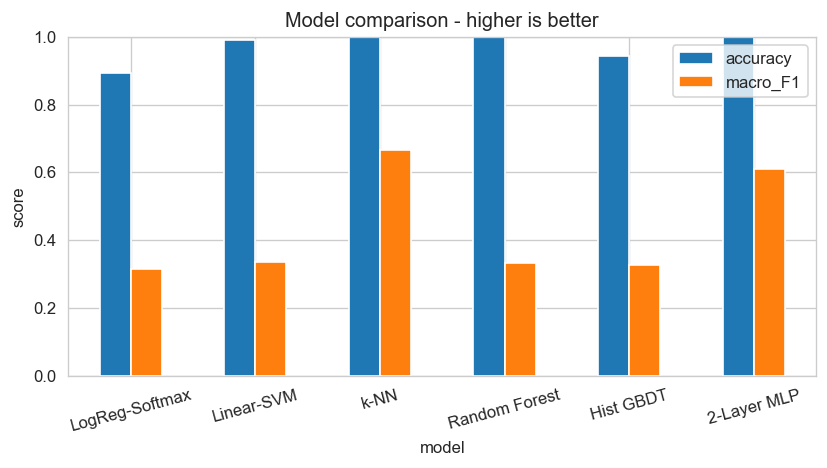

In [41]:
# 4 Visual summaries

# 4-A Accuracy vs. macro-F1
metric_df.plot(kind='bar', figsize=(7,4), rot=15, ylim=(0,1),
               title="Model comparison - higher is better")
plt.ylabel("score"); plt.tight_layout(); plt.show()

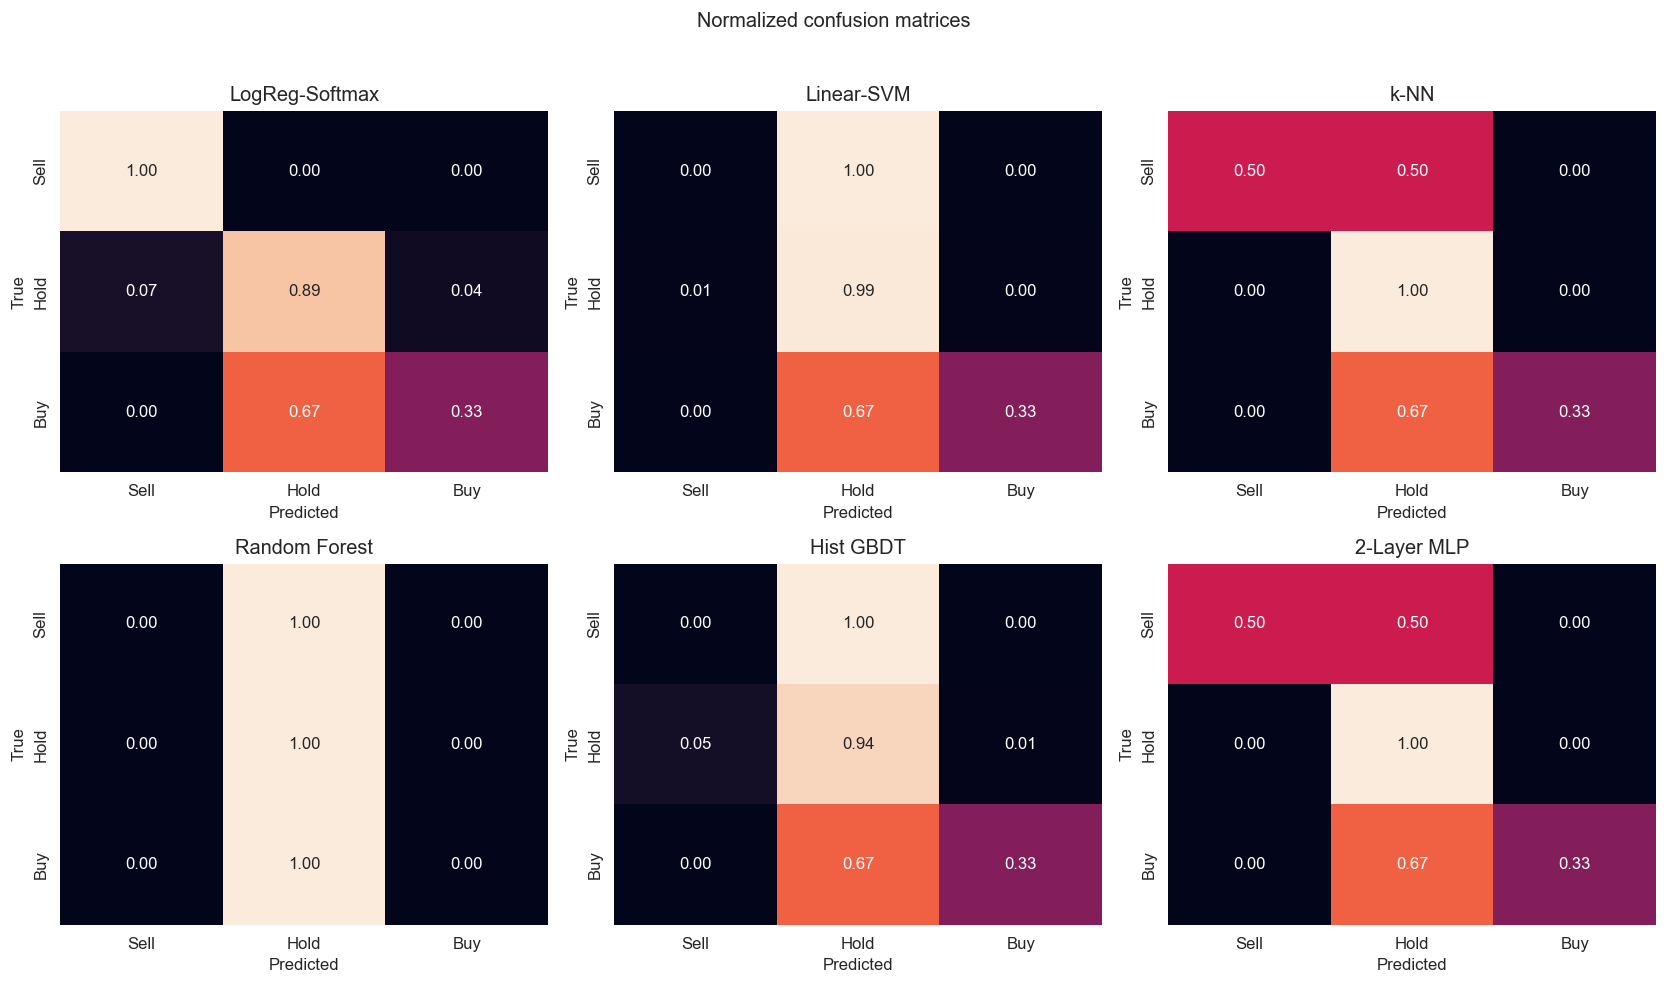

In [44]:
# 4-B Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(14,8))
for ax, (name, cm) in zip(axes.ravel(), cmaps.items()):
    sns.heatmap(cm, annot=True, fmt=".2f", cbar=False,
                xticklabels=["Sell","Hold","Buy"],
                yticklabels=["Sell","Hold","Buy"], ax=ax)
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(name)
plt.suptitle("Normalized confusion matrices", y=1.02)
plt.tight_layout(); plt.show()

/var/folders/p5/gv35v2wx4m7fndc0tw1bvpwm0000gn/T/ipykernel_18270/4126415751.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min


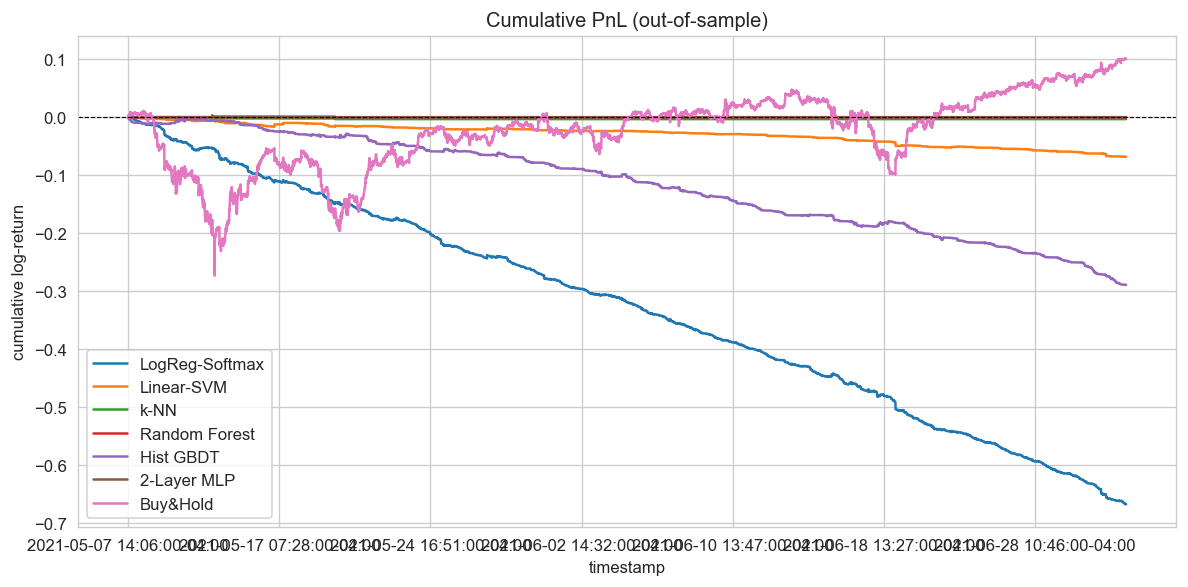

,Sharpe
LogReg-Softmax,-37.80
Linear-SVM,-11.50
k-NN,-2.54
Random Forest,NaN
Hist GBDT,-23.85
2-Layer MLP,-0.17
Buy&Hold,1.22


In [43]:
# 5 Back-test – every model plus Buy & Hold
def backtest(pred, ret, fee_bp=1):
    gross = pred.shift(1) * ret           # enter next bar
    fee   = (pred.diff().abs() > 0).astype(int) * fee_bp/1e4
    return gross - fee

# realised forward log-return you already made
ret_test = fwd_ret_full.loc[idx_test]     # align to y_test timeline

pnl_curves, sharpes = {}, {}
for name, clf in sk_models.items():
    pred = pd.Series(clf.predict(X_test_flat), index=idx_test, name=name)
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min

# --- Buy & Hold baseline ---
bh_pred = pd.Series(1, index=idx_test, name="Buy&Hold")
pnl_bh  = backtest(bh_pred, ret_test, fee_bp=0)             # no fee for hold
pnl_curves["Buy&Hold"] = pnl_bh.cumsum()
sharpes["Buy&Hold"]    = pnl_bh.mean()/pnl_bh.std()*np.sqrt(252*390)

# --- plot curves -----------------------------------------------------------
pd.DataFrame(pnl_curves).plot(figsize=(10,5))
plt.axhline(0, ls='--', lw=0.7, c='k')
plt.title("Cumulative PnL (out-of-sample)")
plt.ylabel("cumulative log-return")
plt.tight_layout()
plt.show()

# --- Sharpe table ----------------------------------------------------------
sharpe_tbl = pd.Series(sharpes).round(2).rename("Sharpe").to_frame()
display(sharpe_tbl)
